In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [162]:
train_data = pd.read_csv("./datasets/titanic/train.csv")
test_data = pd.read_csv("./datasets/titanic/test.csv")

print(train_data.shape)
train_data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [164]:
train_data["Cabin"] = train_data["Cabin"].str[:1]
train_data["Cabin"].fillna("Na", inplace=True)

train_data.loc[train_data["Sex"] == "male", "Sex"] = 1
train_data.loc[train_data["Sex"] == "female", "Sex"] = 0

object_cols = train_data.columns[train_data.dtypes == object]
train_data[object_cols] = train_data[object_cols].astype("string")

test_data["Cabin"] = test_data["Cabin"].str[:1]
test_data["Cabin"].fillna("Na", inplace=True)

test_data.loc[test_data["Sex"] == "male", "Sex"] = 1
test_data.loc[test_data["Sex"] == "female", "Sex"] = 0

object_cols = test_data.columns[test_data.dtypes == object]
test_data[object_cols] = test_data[object_cols].astype("string")
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     889 non-null    string 
dtypes: float64(2), int64(5), string(5)
memory usage: 83.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcla

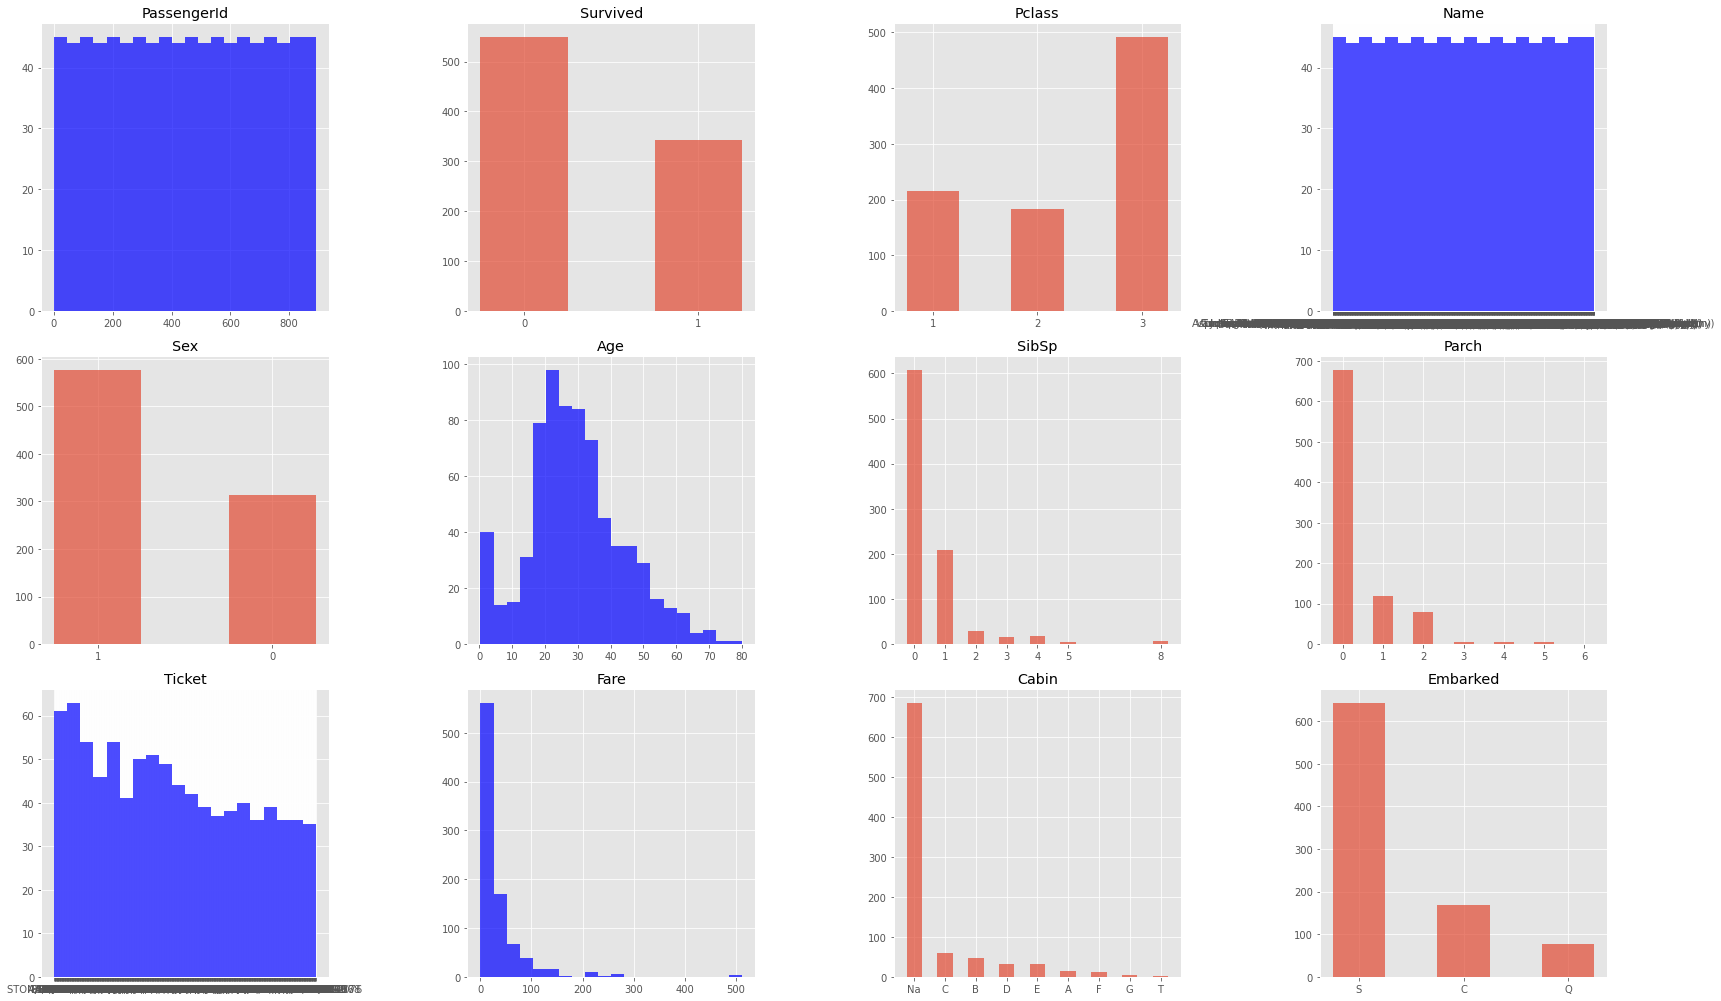

In [165]:
plt.style.use("ggplot")
plt.figure(figsize=(24,20))

cols = train_data.columns
for i in range(len(cols)):
    plt.subplot(4, 4, i+1)
    plt.title(cols[i])
    if len(train_data[cols[i]].unique()) > 20:
        plt.hist(train_data[cols[i]], bins=20, color="b", alpha=0.7)
    else:
        temp = train_data[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

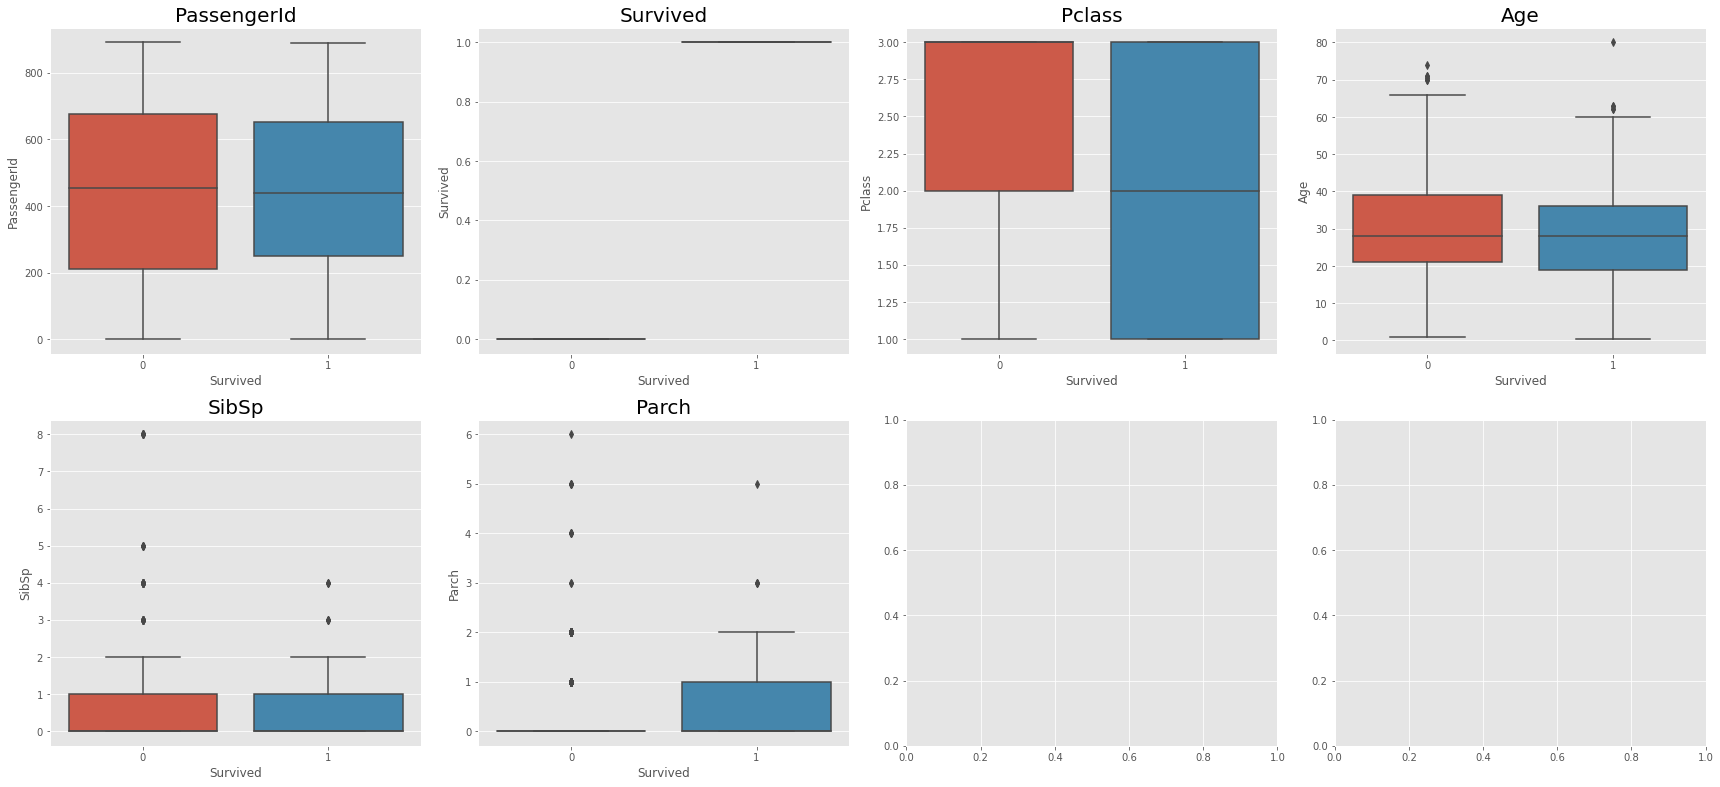

In [166]:
num_data = train_data[train_data.columns[(train_data.dtypes == "int64") | (train_data.dtypes == "float64")]]

fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for ax, col in zip(axes.flat, num_data.columns[:-1]):
    sns.boxplot(x="Survived", y=col, ax=ax, data=num_data)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1. PassengerId 불필요
2. Name특성 너무 많음
3. Age특성 너무 많음
4. Ticket특성 너무 많음
5. SibSp, Parch, Fare특성 너무 좌측편향됨
6. Age, Embarked 결측치

7. SibSp, Parch 이상

방법

1. PassengerId특성 제거
2. Name특성 First, Last로 분해
3. 쏠리지도 않고 괜찮은거같음
4. 미해결
5. 스케일링
6. Age - Pclass별로 나이 구분하여 결측치 해결, Embarked - 이름 같은 사람의 Embarked 복사

7. 합치거나 스케일링

In [167]:
numeric_feature = ["Age", "SibSp", "Parch", "Fare"]
ordinal_feature = ["Pclass"]
categorical_feature = ["Sex", "Cabin", "Embarked"]
too_many_feature = ["Name", "Ticket"]

# train_data["FirstName"], train_data["LastName"] = train_data.Name.str.split(",").str[0], train_data.Name.str.split(",").str[1]
# train_data.drop("Name", axis=1, inplace=True)

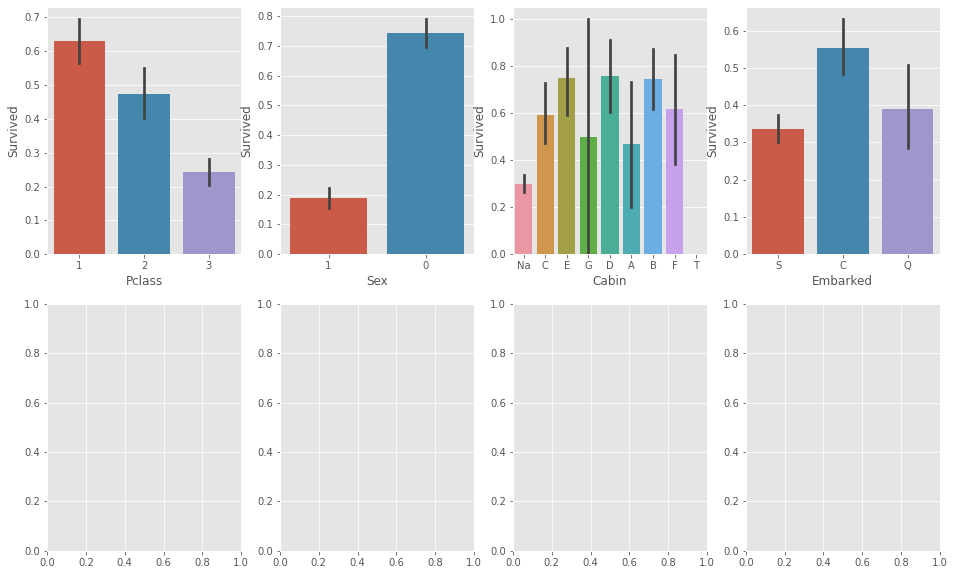

In [168]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))

feature = ordinal_feature + categorical_feature

xvalue = 0
yvalue = 0

for xstr in feature:
    sns.barplot(x=xstr, y="Survived", data=train_data, ax=ax[yvalue][xvalue])
    if xvalue == 3:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

In [169]:
train_data["Family"] = train_data["SibSp"].values + train_data["Parch"].values
test_data["Family"] = test_data["SibSp"].values + test_data["Parch"].values
numeric_feature.append("Family")

for xstr in numeric_feature:
    print(xstr, "Scew: ", train_data[xstr].skew())

Age Scew:  0.38910778230082704
SibSp Scew:  3.6953517271630565
Parch Scew:  2.7491170471010933
Fare Scew:  4.787316519674893
Family Scew:  2.7274414739308535


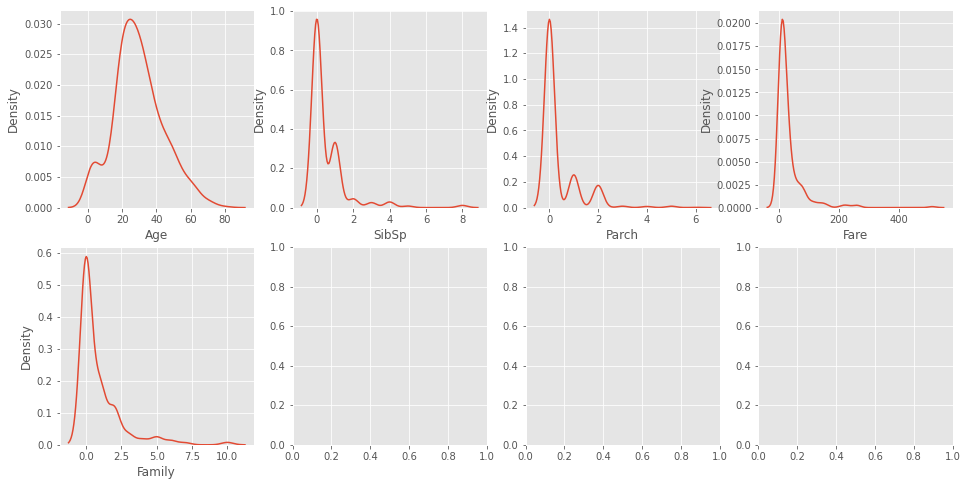

In [170]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

xvalue, yvalue = 0, 0

for index in range(len(numeric_feature)):
    sns.kdeplot(x=numeric_feature[index], data=train_data, ax=ax[yvalue][xvalue])
    if xvalue == 3:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

In [171]:
train_data["SibSp"] = np.log1p(train_data["SibSp"])
train_data["Parch"] = np.log1p(train_data["Parch"])
train_data["Fare"] = np.log1p(train_data["Fare"])
train_data["Family"] = np.log1p(train_data["Family"])

test_data["SibSp"] = np.log1p(test_data["SibSp"])
test_data["Parch"] = np.log1p(test_data["Parch"])
test_data["Fare"] = np.log1p(test_data["Fare"])
test_data["Family"] = np.log1p(test_data["Family"])

In [172]:
for xstr in numeric_feature:
    print(xstr, "Scew: ", train_data[xstr].skew())

Age Scew:  0.38910778230082704
SibSp Scew:  1.6612454204052132
Parch Scew:  1.6754394553891907
Fare Scew:  0.3949280095189306
Family Scew:  1.184008092387092


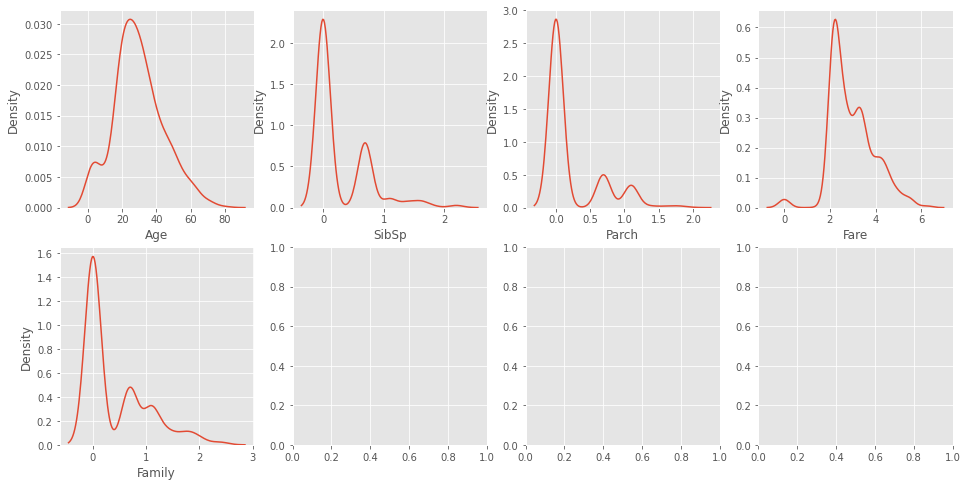

In [173]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

xvalue, yvalue = 0, 0

for index in range(len(numeric_feature)):
    sns.kdeplot(x=numeric_feature[index], data=train_data, ax=ax[yvalue][xvalue])
    if xvalue == 3:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

In [174]:
print("Check train data nan")
print(train_data.info())
print("Check test data nan")
print(test_data.info())

Check train data nan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     889 non-null    string 
 12  Family       891 non-null    float64
dtypes: float64(5), int64(3), string(5)
memory usage: 90.6 KB
None
Check test data nan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  -----

In [175]:
corr_matrix = train_data.corr()
corr_matrix["Age"].sort_values(ascending=False)

Age            1.000000
Fare           0.116495
PassengerId    0.036847
Survived      -0.077221
Parch         -0.248052
SibSp         -0.267173
Family        -0.286287
Pclass        -0.369226
Name: Age, dtype: float64

In [176]:
Pclass1_Age = train_data[train_data["Pclass"] == 1].Age.mean()
train_data.loc[train_data["Pclass"] ==1, "Age"] = train_data.loc[train_data["Pclass"] == 1, "Age"].fillna(Pclass1_Age)

Pclass2_Age = train_data[train_data["Pclass"] == 2].Age.mean()
train_data.loc[train_data["Pclass"] ==2, "Age"] = train_data.loc[train_data["Pclass"] == 2, "Age"].fillna(Pclass2_Age)

Pclass3_Age = train_data[train_data["Pclass"] == 3].Age.mean()
train_data.loc[train_data["Pclass"] ==3, "Age"] = train_data.loc[train_data["Pclass"] == 3, "Age"].fillna(Pclass3_Age)


Pclass1_Age = test_data[test_data["Pclass"] == 1].Age.mean()
test_data.loc[test_data["Pclass"] ==1, "Age"] = test_data.loc[test_data["Pclass"] == 1, "Age"].fillna(Pclass1_Age)

Pclass2_Age = test_data[test_data["Pclass"] == 2].Age.mean()
test_data.loc[test_data["Pclass"] ==2, "Age"] = test_data.loc[test_data["Pclass"] == 2, "Age"].fillna(Pclass2_Age)

Pclass3_Age = test_data[test_data["Pclass"] == 3].Age.mean()
test_data.loc[test_data["Pclass"] ==3, "Age"] = test_data.loc[test_data["Pclass"] == 3, "Age"].fillna(Pclass3_Age)

In [177]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     889 non-null    string 
 12  Family       891 non-null    float64
dtypes: float64(5), int64(3), string(5)
memory usage: 90.6 KB


In [178]:
train_data[train_data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0.0,0.0,113572,4.394449,B,<NA>,0.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0.0,0.0,113572,4.394449,B,<NA>,0.0


In [179]:
train_data["Embarked"].fillna("S", inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     891 non-null    string 
 12  Family       891 non-null    float64
dtypes: float64(5), int64(3), string(5)
memory usage: 90.6 KB


In [180]:
test_data[test_data["Fare"].isnull()]
imputer = KNNImputer()
test_data["Fare"] = imputer.fit_transform(test_data[["Fare"]])

In [181]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     891 non-null    string 
 12  Family       891 non-null    float64
dtypes: float64(5), int64(3), string(5)
memory usage: 90.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

In [182]:
# 이름 처리 어떻게 하지
# nan 처리 끝

In [183]:
train_data.drop(["Name", "PassengerId", "Ticket"], axis=1, inplace=True)
test_data.drop(["Name", "PassengerId", "Ticket"], axis=1, inplace=True)

In [184]:
# train_data.drop("Cabin", axis=1, inplace=True)
# test_data.drop("Cabin", axis=1, inplace=True)

ohe = OneHotEncoder()
train_data["Embarked"] = ohe.fit_transform(train_data[["Embarked"]])

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

전처리 끝

모델 생성 후 학습, 예측

In [ ]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rnd_clf = RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=350, random_state=42, oob_score=True)
rnd_clf.fit(X_train, y_train)
print(rnd_clf.oob_score_)
print(sorted(zip(rnd_clf.feature_importances_, X_train.columns), reverse=True))

print(accuracy_score(y_val, rnd_clf.predict(X_val)))


ValueError: could not convert string to float: 'C'